# Import Dataset

In [19]:
import gc
gc.collect()
import subprocess as sp
import os
def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

get_gpu_memory()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[8214]

In [20]:
import json
from nltk.corpus import stopwords
import re
import json
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
with open('test_dataset.json', 'r') as fp:
    test_dataset = json.load(fp)
with open('train_dataset.json', 'r') as fp:
    train_dataset = json.load(fp)
f = open('/data/data_codebook.json')
data_codebook = json.load(f)
super_set={}
for s in data_codebook:
    if s[2]!="domain_name":
        if s[2] not in super_set:
            super_set[s[2]]=[]
        if s[5] not in super_set[s[2]]:
            super_set[s[2]].append(s[5])

In [21]:
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, roc_auc_score, classification_report, confusion_matrix
# import all the metrics we'll use later on
from sklearn.metrics import precision_score,recall_score


sw = stopwords.words('english')

def clean_text(text):
    
    text = text.lower()
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    #text = re.sub(r"http", "",text)
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Removing html tags
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = " ".join(text) #removing stopwords
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis
    
    return text

In [22]:
# load tokens
from transformers import AutoTokenizer
# load base package for the tasks from pytorch
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

# Function to calculate the accuracy of our predictions vs labels
import time
import datetime
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
test_manifesto_dataframe=[]
for k,v in test_dataset.items():
    for key, value in super_set.items():
        if k in value:
            super_label = key
    for s in v:
            per_line_dict = {}
            per_line_dict["sentence"] = s
            per_line_dict["detailed_label"] = k
            per_line_dict["general_label"] = super_label
            test_manifesto_dataframe.append(per_line_dict)

test_manifesto_dataframe = pd.DataFrame(data=(test_manifesto_dataframe))
test_manifesto_dataframe=shuffle(test_manifesto_dataframe).dropna()
test_manifesto_dataframe

,sentence,detailed_label,general_label
19264,Responsible fiscal policy,Technology and Infrastructure: Positive,Economy
21288,We will increase the tonnage of the Croatian ...,Technology and Infrastructure: Positive,Economy
61321,"We prepared ""The Situation of the Elderly in ...",Non-economic Demographic Groups,Social Groups
54649,Extension of the requirement for environmenta...,Environmental Protection,Welfare and Quality of Life
38279,Imposition of expulsion already by the crimin...,Law and Order: Positive,Fabric of Society
...,...,...,...
19393,Currently there are many open source projects...,Technology and Infrastructure: Positive,Economy
37970,Deduction of personal and criminal responsibi...,Law and Order: Positive,Fabric of Society
22156,"According to experts, Lithuanian research and...",Technology and Infrastructure: Positive,Economy
6062,An enormous investment cycle and parallelism ...,Welfare State Expansion,Welfare and Quality of Life


# Transferability test: ClimateBert/Environmental_claims dataset

In [24]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from transformers.pipelines.pt_utils import KeyDataset
import datasets
from tqdm.auto import tqdm

dataset_name = "climatebert/environmental_claims"
# If you want to use your own data, simply load them as 🤗 Datasets dataset, see https://huggingface.co/docs/datasets/loading
climatebert = datasets.load_dataset(dataset_name)

In [25]:
climatebert

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2117
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 265
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 265
    })
})

In [26]:
climatebert_dataset=[]
for k,v in climatebert.items():
    for sentence in v:
        climatebert_dataset.append(sentence)
print("Number of sentences once the train,validation and test sets of Climatebert dataset was combined:",len(climatebert_dataset))
climatebert_text_original=[]
climatebert_text=[]
climatebert_labels=[]
for item in climatebert_dataset:
    climatebert_text_original.append(item['text'])
    cleaned_text=clean_text(item['text'])
    climatebert_text.append(cleaned_text)
    climatebert_labels.append(item["label"])
print(len(climatebert_text)==len(climatebert_labels))

Number of sentences once the train,validation and test sets of Climatebert dataset was combined: 2647
True


max:  62
min:  4


(array([  0., 100., 200., 300., 400., 500., 600., 700., 800.]),
 [Text(0, 0.0, '0'),
  Text(0, 100.0, '100'),
  Text(0, 200.0, '200'),
  Text(0, 300.0, '300'),
  Text(0, 400.0, '400'),
  Text(0, 500.0, '500'),
  Text(0, 600.0, '600'),
  Text(0, 700.0, '700'),
  Text(0, 800.0, '800')])

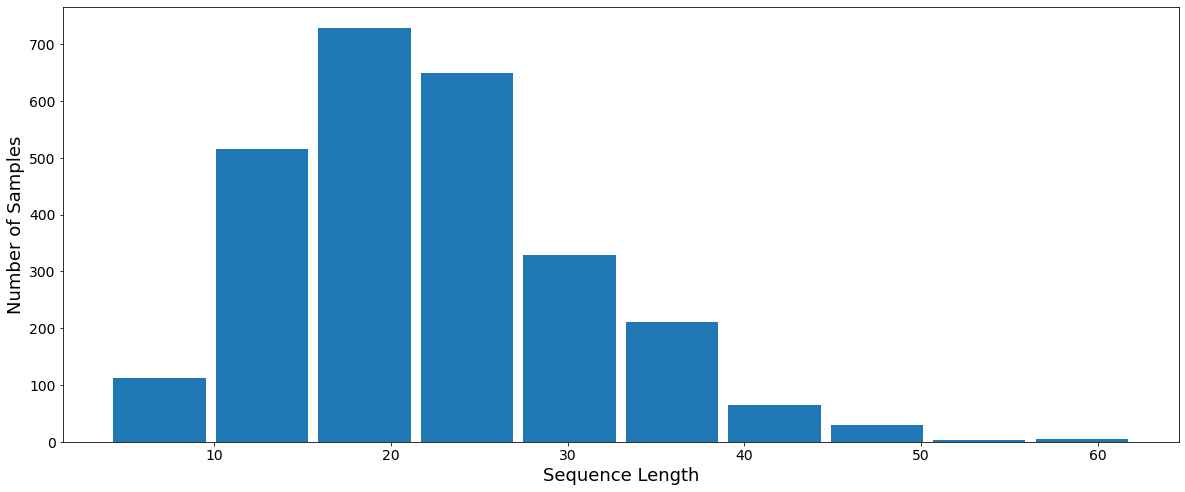

In [27]:
# tokenize the text feature 
climatebert_tokenized_feature = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            climatebert_text, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True      
                   )
# collect tokenized sentence length 
token_sentence_length = [len(x) for x in climatebert_tokenized_feature['input_ids']]
print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))
MAX_LEN = max(token_sentence_length)
# plot the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.hist(token_sentence_length, rwidth = 0.9)
plt.xlabel('Sequence Length', fontsize = 18)
plt.ylabel('Number of Samples', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

In [28]:
#LOAD the model
model = torch.load('Roberta_10percent_OneStep')

In [29]:
climatebert_tokenized_feature = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            climatebert_text, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            # Add empty tokens if len(text)<MAX_LEN
                            padding = 'max_length',
                            # Truncate all sentences to max length
                            truncation=True,
                            # Set the maximum length
                            max_length = MAX_LEN, 
                            # Return attention mask
                            return_attention_mask = True,
                            # Return pytorch tensors
                            return_tensors = 'pt'    )


batch_size=16
# Create the DataLoader for the climatebert dataset
climatebert_validation_data = TensorDataset(climatebert_tokenized_feature['input_ids'], climatebert_tokenized_feature['attention_mask'], torch.tensor(climatebert_labels))
validation_sampler = SequentialSampler(climatebert_validation_data)
climatebert_validation_dataloader = DataLoader(climatebert_validation_data, sampler=validation_sampler, batch_size=batch_size)

In [30]:
# Test
import numpy as np
t0 = time.time()
# model in validation mode
model.eval()
# save prediction
predictions,true_labels =[],[]
# evaluate data for one epoch
for batch in climatebert_validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # validation
    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)
    # get output
    logits = outputs[0]
    # move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    final_prediction = np.argmax(logits, axis=-1).flatten()
    predictions.append(final_prediction)
    true_labels.append(label_ids)
    
print('total time used is: {0:.2f} s'.format(time.time() - t0))

total time used is: 5.95 s


In [31]:
print("Testing Claim dataset by the model trained on Manifesto dataset")
print()
from sklearn.metrics import f1_score
# convert numeric label to string
final_prediction_list = np.concatenate(predictions)

# Evaluate precision
precision = precision_score(climatebert_labels, final_prediction_list)
# Evaluate recall
recall = recall_score(climatebert_labels, final_prediction_list)

# Evaluate accuracy
accuracy = accuracy_score(climatebert_labels, final_prediction_list)

# Evaluate F1-score
f1_score = f1_score(climatebert_labels, final_prediction_list, average='weighted')

# Evaluate balanced accuracy
balanced_accuracy = balanced_accuracy_score(climatebert_labels, final_prediction_list)


# Print evaluation metrics for Linear SVC on the unseen test set
print("Precision on Unseen Test Set:", round(precision,2))
print("Recall on Unseen Test Set:", round(recall,2))
print()
print("Accuracy on Unseen Test Set:", round(accuracy,2))
print("F1-Score on Unseen Test Set:", round(f1_score,2))
print("Balanced Accuracy on Unseen Test Set:", round(balanced_accuracy,2))
print()

# Print classification report and confusion matrix for Linear SVC on the unseen test set
print("Classification Report on Unseen Test Set:")
print(classification_report(climatebert_labels, final_prediction_list))
print("Confusion Matrix on Unseen Test Set:")
print(confusion_matrix(climatebert_labels, final_prediction_list))

Testing Claim dataset by the model trained on Manifesto dataset

Precision on Unseen Test Set: 0.52
Recall on Unseen Test Set: 0.77

Accuracy on Unseen Test Set: 0.77
F1-Score on Unseen Test Set: 0.78
Balanced Accuracy on Unseen Test Set: 0.77

Classification Report on Unseen Test Set:
              precision    recall  f1-score   support

           0       0.91      0.77      0.83      1982
           1       0.52      0.77      0.62       665

    accuracy                           0.77      2647
   macro avg       0.72      0.77      0.73      2647
weighted avg       0.81      0.77      0.78      2647

Confusion Matrix on Unseen Test Set:
[[1517  465]
 [ 155  510]]


In [9]:
def dict_for_error_analysis(text_list, true_labels, predicted_labels):
    trained_dict = {}

    for n, (text, true_label, predicted_label) in enumerate(zip(text_list, true_labels, predicted_labels), start=1):
        trained_dict[str(n)] = {
            "sentence": text,
            "true_label": str(true_label),
            "predicted_label": str(predicted_label)
        }

    final_list = [v for k, v in trained_dict.items()]
    return final_list

Tested_claims_trained_manifesto=dict_for_error_analysis(climatebert_text_original,climatebert_labels,final_prediction_list)
import json

In [32]:
import json
output_file = open("Tested_claims_trained_manifesto.txt", 'w', encoding='utf-8')
for dic in Tested_claims_trained_manifesto:
    json.dump(dic, output_file) 
    output_file.write("\n")

# Inverse: train on Claim dataset and test on Manifesto

In [14]:
# load tokens
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
# Use 80% for training and 20% for validation
print(len(climatebert_text)==len(climatebert_labels))
from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(climatebert_tokenized_feature['input_ids'], 
                                                                                                             climatebert_labels,
                                                                                                                    climatebert_tokenized_feature['attention_mask'],
                                                                                                      random_state=42, test_size=0.2, stratify=climatebert_labels)

True


In [14]:
# load base package for the tasks from pytorch
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# define batch_size
batch_size = 16
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# Create the DataLoader for our test set
validation_data = TensorDataset(validation_inputs, validation_masks, torch.tensor(validation_labels))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [15]:
# BertForSequenceClassification
from transformers import XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", 
    # Specify number of classes
    num_labels = len(set(climatebert_labels)), 
    # Whether the model returns attentions weights
    output_attentions = False,
    # Whether the model returns all hidden-states 
    output_hidden_states = False
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Receive the full size of the new word
model.resize_token_embeddings(len(tokenizer))
# Optimizer & Learning Rate Scheduler
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

# Number of training epochs
epochs = 3
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# tell pytorch to run this model on GPU
model.cuda()

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 250002. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
/home/users/yabdul/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0): XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tr

In [17]:
import random
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the device using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)        
        loss = output.loss
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    best_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            output= model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()
        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model, 'inverse_climatebert_trained')
        best_eval_accuracy = avg_val_accuracy
    #print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    #print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...

  Average training loss: 0.46
  Training epcoh took: 0:00:23

Running Validation...
  Accuracy: 0.78

======== Epoch 2 / 3 ========
Training...

  Average training loss: 0.29
  Training epcoh took: 0:00:23

Running Validation...
  Accuracy: 0.89

======== Epoch 3 / 3 ========
Training...

  Average training loss: 0.22
  Training epcoh took: 0:00:23

Running Validation...
  Accuracy: 0.91

Training complete!
Total training took 0:01:35 (h:mm:ss)


In [15]:
model = torch.load('inverse_climatebert_trained')

In [10]:
def preprocess_data(dataframe):
    
    sentences_cleaned = [clean_text(s) for s in dataframe["sentence"]]
    labels_numbers = [1 if s == 'Environmental Protection' else 0 for s in dataframe["detailed_label"]]
    return sentences_cleaned, labels_numbers


dataframe =test_manifesto_dataframe.copy()
manifesto_original_sentences= [s for s in dataframe["sentence"]]
manifesto_sentences_cleaned,manifesto_labels=preprocess_data(dataframe)
print(len(manifesto_sentences_cleaned)==len(manifesto_labels))

True


In [11]:
# tokenize features 
MAX_LEN = 135
manifesto_tokenized_feature = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            manifesto_sentences_cleaned, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            # Add empty tokens if len(text)<MAX_LEN
                            padding = 'max_length',
                            # Truncate all sentences to max length
                            truncation=True,
                            # Set the maximum length
                            max_length = MAX_LEN, 
                            # Return attention mask
                            return_attention_mask = True,
                            # Return pytorch tensors
                            return_tensors = 'pt')

In [12]:
batch_size=16
# Create the DataLoader for the climatebert dataset
manifesto_validation_data = TensorDataset(manifesto_tokenized_feature['input_ids'], manifesto_tokenized_feature['attention_mask'], torch.tensor(manifesto_labels))
validation_sampler = SequentialSampler(manifesto_validation_data)
manifesto_validation_dataloader = DataLoader(manifesto_validation_data, sampler=validation_sampler, batch_size=batch_size)

In [20]:
# Test
import numpy as np
t0 = time.time()
# model in validation mode
model.eval()
# save prediction
predictions,true_labels =[],[]
# evaluate data for one epoch
for batch in manifesto_validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # validation
    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)
    # get output
    logits = outputs[0]
    # move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    final_prediction = np.argmax(logits, axis=-1).flatten()
    predictions.append(final_prediction)
    true_labels.append(label_ids)
    
print('total time used is: {0:.2f} s'.format(time.time() - t0))

total time used is: 421.07 s


In [21]:
print("Testing Manifesto dataset by the model trained on Claims dataset")
print()
from sklearn.metrics import f1_score
# convert numeric label to string
final_prediction_list = np.concatenate(predictions)

# Evaluate precision
precision = precision_score(manifesto_labels, final_prediction_list)
# Evaluate recall
recall = recall_score(manifesto_labels, final_prediction_list)

# Evaluate accuracy
accuracy = accuracy_score(manifesto_labels, final_prediction_list)

# Evaluate F1-score
f1_score = f1_score(manifesto_labels, final_prediction_list, average='weighted')

# Evaluate balanced accuracy
balanced_accuracy = balanced_accuracy_score(manifesto_labels, final_prediction_list)

# Print evaluation metrics for Linear SVC on the unseen test set
print("Precision on Unseen Test Set:", round(precision,2))
print("Recall on Unseen Test Set:", round(recall,2))
print()
print("Accuracy on Unseen Test Set:", round(accuracy,2))
print("F1-Score on Unseen Test Set:", round(f1_score,2))
print("Balanced Accuracy on Unseen Test Set:", round(balanced_accuracy,2))
print()

# Print classification report and confusion matrix for Linear SVC on the unseen test set
print("Classification Report on Unseen Test Set:")
print(classification_report(manifesto_labels, final_prediction_list))
print("Confusion Matrix on Unseen Test Set:")
print(confusion_matrix(manifesto_labels, final_prediction_list))

Testing Manifesto dataset by the model trained on Claims dataset

Precision on Unseen Test Set: 0.49
Recall on Unseen Test Set: 0.39

Accuracy on Unseen Test Set: 0.91
F1-Score on Unseen Test Set: 0.91
Balanced Accuracy on Unseen Test Set: 0.67

Classification Report on Unseen Test Set:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     77385
           1       0.49      0.39      0.43      7475

    accuracy                           0.91     84860
   macro avg       0.71      0.67      0.69     84860
weighted avg       0.90      0.91      0.91     84860

Confusion Matrix on Unseen Test Set:
[[74335  3050]
 [ 4597  2878]]


In [25]:
Test_manifesto_train_Claims=dict_for_error_analysis(manifesto_original_sentences,manifesto_labels,final_prediction_list)
output_file = open("Test_manifesto_train_Claims_right.txt", 'w', encoding='utf-8')
for dic in Test_manifesto_train_Claims:
    json.dump(dic, output_file) 
    output_file.write("\n")

# Transferability test: 10Ks dataset

In [52]:
import pandas as pd
test_10ks = pd.read_csv ("10-Ks (2018, test).tsv", sep = '\t')
train_10ks= pd.read_csv ("AL-10Ks.tsv _ 3000 (58 positives, 2942 negatives) (TSV, 127138 KB).tsv", sep = '\t')
train_10ks["sentence_cleaned"] = train_10ks["sentence"].apply(lambda x: clean_text(x))
train_text_cleaned=list(train_10ks["sentence_cleaned"])
train_labels=list(train_10ks["label"])
test_10ks["sentence_cleaned"] = test_10ks["sentence"].apply(lambda x: clean_text(x))
test_text_cleaned=list(test_10ks["sentence_cleaned"])
test_labels=list(test_10ks["label"])
train_text_cleaned.extend(test_text_cleaned)
train_labels.extend(test_labels)

original_text_10ks=list(train_10ks["sentence"])
original_text_10ks.extend(list(test_10ks["sentence"]))

max:  127
min:  3


(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.]),
 [Text(0, 0.0, '0'),
  Text(0, 200.0, '200'),
  Text(0, 400.0, '400'),
  Text(0, 600.0, '600'),
  Text(0, 800.0, '800'),
  Text(0, 1000.0, '1000'),
  Text(0, 1200.0, '1200'),
  Text(0, 1400.0, '1400')])

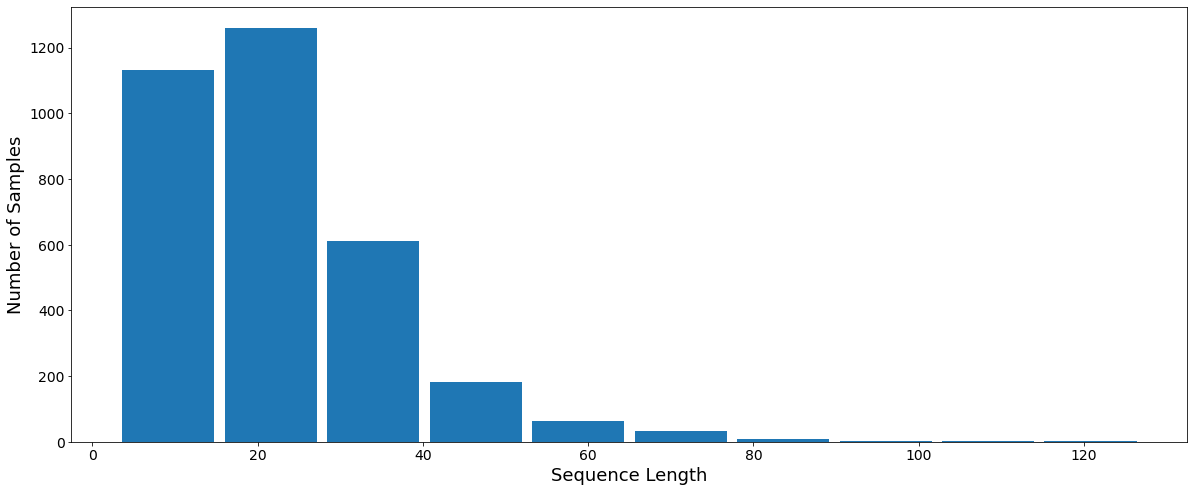

In [53]:
# tokenize the text feature 
Ks10_tokenized_feature = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            train_text_cleaned, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True      
                   )
# collect tokenized sentence length 
token_sentence_length = [len(x) for x in Ks10_tokenized_feature['input_ids']]
print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))
MAX_LEN = max(token_sentence_length)
# plot the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.hist(token_sentence_length, rwidth = 0.9)
plt.xlabel('Sequence Length', fontsize = 18)
plt.ylabel('Number of Samples', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

In [54]:
Ks10_tokenized_feature = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            train_text_cleaned, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            # Add empty tokens if len(text)<MAX_LEN
                            padding = 'max_length',
                            # Truncate all sentences to max length
                            truncation=True,
                            # Set the maximum length
                            max_length = MAX_LEN, 
                            # Return attention mask
                            return_attention_mask = True,
                            # Return pytorch tensors
                            return_tensors = 'pt'    )


batch_size=16
# Create the DataLoader for the climatebert dataset
Ks10_validation_data = TensorDataset(Ks10_tokenized_feature['input_ids'],Ks10_tokenized_feature['attention_mask'], torch.tensor(train_labels))
validation_sampler = SequentialSampler(Ks10_validation_data)
Ks10_validation_dataloader = DataLoader(Ks10_validation_data, sampler=validation_sampler, batch_size=batch_size)

In [55]:
#LOAD the model
model = torch.load('Roberta_10percent_OneStep')

In [56]:
# Test
import numpy as np
t0 = time.time()
# model in validation mode
model.eval()
# save prediction
predictions,true_labels =[],[]
# evaluate data for one epoch
for batch in Ks10_validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # validation
    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)
    # get output
    logits = outputs[0]
    # move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    final_prediction = np.argmax(logits, axis=-1).flatten()
    predictions.append(final_prediction)
    true_labels.append(label_ids)
    
print('total time used is: {0:.2f} s'.format(time.time() - t0))

total time used is: 13.11 s


In [71]:
print("Test on 10-K files dataset")
print()
from sklearn.metrics import f1_score
final_prediction_list =list(np.concatenate(predictions)) 
# Evaluate precision
precision = precision_score(train_labels, final_prediction_list)
# Evaluate recall
recall = recall_score(train_labels, final_prediction_list)
# Evaluate accuracy
accuracy = accuracy_score(train_labels, final_prediction_list)

# Evaluate F1-score
f1_score = f1_score(train_labels, final_prediction_list, average='weighted')

# Evaluate balanced accuracy
balanced_accuracy = balanced_accuracy_score(train_labels, final_prediction_list)

# Print evaluation metrics for Linear SVC on the unseen test set
print("Precision on Unseen Test Set:", round(precision,2))
print("Recall on Unseen Test Set:", round(recall,2))
print()
print("Accuracy on Unseen Test Set:", round(accuracy,2))
print("F1-Score on Unseen Test Set:", round(f1_score,2))
print("Balanced Accuracy on Unseen Test Set:", round(balanced_accuracy,2))
print()

# Print classification report and confusion matrix for Linear SVC on the unseen test set
print("Classification Report on Unseen Test Set:")
print(classification_report(train_labels, final_prediction_list))
print("Confusion Matrix on Unseen Test Set:")
print(confusion_matrix(train_labels, final_prediction_list))

Test on 10-K files dataset

Precision on Unseen Test Set: 0.3
Recall on Unseen Test Set: 0.74

Accuracy on Unseen Test Set: 0.93
F1-Score on Unseen Test Set: 0.94
Balanced Accuracy on Unseen Test Set: 0.84

Classification Report on Unseen Test Set:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      3175
           1       0.30      0.74      0.43       125

    accuracy                           0.93      3300
   macro avg       0.65      0.84      0.70      3300
weighted avg       0.96      0.93      0.94      3300

Confusion Matrix on Unseen Test Set:
[[2963  212]
 [  32   93]]


In [73]:
Test_10ks_train_mainfesto=dict_for_error_analysis(original_text_10ks,train_labels,final_prediction_list)
output_file = open("Test_10ks_train_mainfesto.txt", 'w', encoding='utf-8')
for dic in Test_10ks_train_mainfesto:
    json.dump(dic, output_file) 
    output_file.write("\n")

# Inverse: trained on 10KS, tested on Manifesto

In [79]:
# load tokens
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
# Use 80% for training and 20% for validation

from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(Ks10_tokenized_feature['input_ids'], 
                                                                                                             train_labels,
                                                                                                                    Ks10_tokenized_feature['attention_mask'],
                                                                                                      random_state=42, test_size=0.2, stratify=train_labels)

In [81]:
# load base package for the tasks from pytorch
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# define batch_size
batch_size = 16
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# Create the DataLoader for our test set
validation_data = TensorDataset(validation_inputs, validation_masks, torch.tensor(validation_labels))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# BertForSequenceClassification
from transformers import XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", 
    # Specify number of classes
    num_labels = len(set(train_labels)), 
    # Whether the model returns attentions weights
    output_attentions = False,
    # Whether the model returns all hidden-states 
    output_hidden_states = False
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [82]:
# Receive the full size of the new word
model.resize_token_embeddings(len(tokenizer))
# Optimizer & Learning Rate Scheduler
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

# Number of training epochs
epochs = 3
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# tell pytorch to run this model on GPU
model.cuda()

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 250002. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
/home/users/yabdul/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0): XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tr

In [83]:
import random
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the device using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)        
        loss = output.loss
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    best_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            output= model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()
        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model, 'inverse_10ks_trained')
        best_eval_accuracy = avg_val_accuracy
    #print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    #print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...

  Average training loss: 0.20
  Training epcoh took: 0:00:40

Running Validation...
  Accuracy: 0.96

======== Epoch 2 / 3 ========
Training...

  Average training loss: 0.16
  Training epcoh took: 0:00:40

Running Validation...
  Accuracy: 0.96

======== Epoch 3 / 3 ========
Training...

  Average training loss: 0.14
  Training epcoh took: 0:00:40

Running Validation...
  Accuracy: 0.96

Training complete!
Total training took 0:04:07 (h:mm:ss)


In [13]:
model = torch.load('inverse_10ks_trained')

In [14]:
# tokenize features 
MAX_LEN = 135
manifesto_tokenized_feature = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            manifesto_sentences_cleaned, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            # Add empty tokens if len(text)<MAX_LEN
                            padding = 'max_length',
                            # Truncate all sentences to max length
                            truncation=True,
                            # Set the maximum length
                            max_length = MAX_LEN, 
                            # Return attention mask
                            return_attention_mask = True,
                            # Return pytorch tensors
                            return_tensors = 'pt')

batch_size=16
# Create the DataLoader for the climatebert dataset
manifesto_validation_data = TensorDataset(manifesto_tokenized_feature['input_ids'], manifesto_tokenized_feature['attention_mask'], torch.tensor(manifesto_labels))
validation_sampler = SequentialSampler(manifesto_validation_data)
manifesto_validation_dataloader = DataLoader(manifesto_validation_data, sampler=validation_sampler, batch_size=batch_size)

In [15]:
# Test
import numpy as np
t0 = time.time()
# model in validation mode
model.eval()
# save prediction
predictions,true_labels =[],[]
# evaluate data for one epoch
for batch in manifesto_validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # validation
    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)
    # get output
    logits = outputs[0]
    # move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    final_prediction = np.argmax(logits, axis=-1).flatten()
    predictions.append(final_prediction)
    true_labels.append(label_ids)
    
print('total time used is: {0:.2f} s'.format(time.time() - t0))

total time used is: 419.96 s


In [16]:
print("Testing on Manifesto dataset by the model trained on 10KS dataset")
print()
from sklearn.metrics import f1_score

# convert numeric label to string
final_prediction_list = np.concatenate(predictions)
# Evaluate precision
precision = precision_score(manifesto_labels, final_prediction_list, average='weighted')
# Evaluate recall
recall = recall_score(manifesto_labels, final_prediction_list, average='weighted')
# Evaluate accuracy
accuracy = accuracy_score(manifesto_labels, final_prediction_list)

# Evaluate F1-score
f1_score = f1_score(manifesto_labels, final_prediction_list, average='weighted')

# Evaluate balanced accuracy
balanced_accuracy = balanced_accuracy_score(manifesto_labels, final_prediction_list)

# Print evaluation metrics for Linear SVC on the unseen test set
print("Precision on Unseen Test Set:", round(precision,2))
print("Recall on Unseen Test Set:", round(recall,2))
print()
print("Accuracy on Unseen Test Set:", round(accuracy,2))
print("F1-Score on Unseen Test Set:", round(f1_score,2))
print("Balanced Accuracy on Unseen Test Set:", round(balanced_accuracy,2))
print()

# Print classification report and confusion matrix for Linear SVC on the unseen test set
print("Classification Report on Unseen Test Set:")
print(classification_report(manifesto_labels, final_prediction_list))
print("Confusion Matrix on Unseen Test Set:")
print(confusion_matrix(manifesto_labels, final_prediction_list))

Testing on Manifesto dataset by the model trained on 10KS dataset



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision on Unseen Test Set: 0.83
Recall on Unseen Test Set: 0.91

Accuracy on Unseen Test Set: 0.91
F1-Score on Unseen Test Set: 0.87
Balanced Accuracy on Unseen Test Set: 0.5

Classification Report on Unseen Test Set:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     77385
           1       0.00      0.00      0.00      7475

    accuracy                           0.91     84860
   macro avg       0.46      0.50      0.48     84860
weighted avg       0.83      0.91      0.87     84860

Confusion Matrix on Unseen Test Set:
[[77385     0]
 [ 7475     0]]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
Test_manifesto_train_10ks=dict_for_error_analysis(manifesto_original_sentences,manifesto_labels,final_prediction_list)
output_file = open("Test_manifesto_train_10ks_right.txt", 'w', encoding='utf-8')
for dic in Test_manifesto_train_10ks:
    json.dump(dic, output_file) 
    output_file.write("\n")